# PSD Classification

- Prepare Xy
    - include only experience rows in X
    - Prepare connectivity dataset
- fit a simple svm classifier
- hyperparameters tuning (Grid search)
- model based feature selection
- feature scaling
- cross validated score
- permutation test plot
- dummy classifier for chance level
- arbitrary scores (accuracy and auc)
- permutation importance plot
- SHAP values

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

DATA = pd.read_csv('data/classification_dataset.csv', index_col=0)
DATA = DATA.query('not condition.str.contains("baseline")', engine='python')

# Xy
X = DATA.drop(columns=['hypnosis_depth', 'bids_id', 'condition', 'procedure', 'description', 'session'])
hypnosis_depth_median = DATA['hypnosis_depth'].median()
y = DATA['hypnosis_depth'].apply(lambda x: 'low' if x <= hypnosis_depth_median  else 'high')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# prepare connectivity data

X_conn = np.random.rand(50, 58, 58)
X_conn = np.array([xi[np.triu_indices(X_conn.shape[-1], k=0)] for xi in X_conn])

conn_labels = pd.DataFrame(columns=[f'{i}' for i in range(58)], index=[f'{i}' for i in range(58)])
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

In [66]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('reduce', PCA()),
    ('clf', SVC(kernel='linear', probability=True)),
    # ('clf', DummyClassifier(strategy='uniform'))
])

# param_grid = {
#     'scale': [StandardScaler(), 'passthrough'],
#     'select': [SelectFromModel(SVC(kernel='linear')), 'passthrough'],
#     'clf': [SVC(kernel='linear', probability=True,),
#             RandomForestClassifier()],
# }

param_grid = [
    {
        'scale': ['passthrough'],
        'select': ['passthrough'],
        'reduce': [PCA(n_components=i) for i in range(1, 10)],
        'clf': [SVC(probability=True)],
        # 'clf__C': [0.1, 1, 10, 100],
        # 'clf__gamma': [0.001, 0.0001],
        # 'clf__kernel': ['rbf', 'linear']
    },
    # {
    #     'scale': [StandardScaler(), 'passthrough'],
    #     'select': [SelectKBest()],
    #     'select__k': [10, 20, 50, 'all'],
    #     'clf': [RandomForestClassifier()],
    #     'clf__n_estimators': [10, 100]
    # },  
]

grid = GridSearchCV(pipe, param_grid,
                    scoring=['roc_auc', 'accuracy'],
                    refit='accuracy',
                    n_jobs=-1,
                    verbose=3)

In [71]:
%conda install -c conda-forge scikit-optimize

Solving environment: done

## Package Plan ##

  environment location: /Users/yeganeh/miniconda3

  added / updated specs:
    - scikit-optimize


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h5eb16cf_7          18 KB  conda-forge
    brotli-bin-1.0.9           |       h5eb16cf_7          17 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    fonttools-4.31.2           |   py39h63b48b0_1         1.6 MB  conda-forge
    freetype-2.10.4            |       h4cff582_1         890 KB  conda-forge
    giflib-5.2.1               |       hbcb3906_2          71 KB  conda-forge
    kiwisolver-1.4.2           |   py39h7248d28_1          62 KB  conda-forge
    lcms2-2.12                 |       hf1fd2bf_0         284 KB
    libbrotlicommon-1.0.9      |       h5eb16cf_7          63 KB  conda-forge
    libbrotlidec-1.0

In [ ]:
import 

In [ ]:
scores = []

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    grid.fit(X, y)
    pipe = grid.best_estimator_
    pipe.fit(X.iloc[train], y.iloc[train])
    score = pipe.score(X.iloc[test], y.iloc[test])
    # y_pred_prop = pipe.predict_proba(X.iloc[test])[:, 1]
    # score = roc_auc_score(y.iloc[test], y_pred_prop)
    scores.append(score)

print(np.mean(scores), np.std(scores))

In [4]:
# permutation test
from sklearn.model_selection import permutation_test_score

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='roc_auc', n_permutations=100, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, 

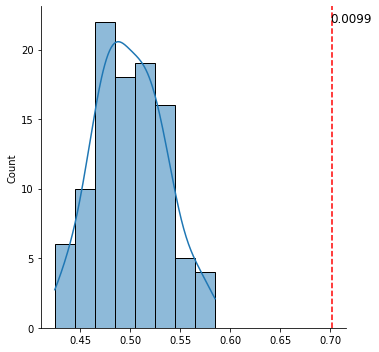

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: improve visualization
sns.displot(perm_socres, kde=True)
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [6]:
from sklearn.inspection import permutation_importance

importances = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    perm_imp_results = permutation_importance(
        pipe, X, y, scoring='roc_auc', n_repeats=2, n_jobs=-1)
    importances.append(perm_imp_results['importances'])

importances

100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


[array([[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [6.07902736e-02, 7.23784195e-02],
        [0.00000000e+00, 0.00000000e+00],
        [1.37870441e-01, 1.31435220e-01],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [8.80984043e-02, 1.08520137e-01],
        [1.59218275e-01, 1.43118351e-01],
        [0.00000000e+00, 0.00000000e+00],
        [4.78011018e-02, 4.56164514e-02],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [1.85101634e-01, 1.62067819e-01],
        [1.26234802e-01, 1.03557181e-01],
        [0.00000000e+00, 0.00000000e+00],
        [1.14979103e-01, 9.04730243e-02],
        [0.00000000e+00, 0.00000000e+00],
        [1.35092135e-01, 1.66057181e-01],
        [0.00000000e+00, 0.00000000e+00],
        [1.01063830e-01, 1.23385258e-01],
        [0.00000000e+00, 0.00000000e+00],
        [3.37908435e-02, 5.4283814

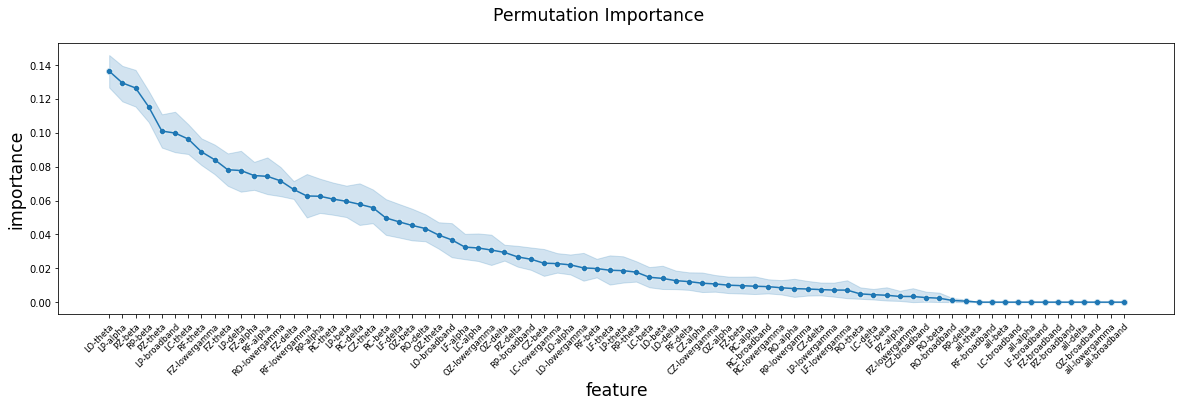

In [7]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()

In [55]:
# SHAP

# %conda install -c conda-forge shap

import shap

shap_values_cv = []
X_test_indexes_cv = []
y_test_cv = []
y_pred_cv = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    y_pred = pipe.predict(X.iloc[test])
    # TODO: check if model is a treebased one, otherwise use shap.Explainer and clf.predict_proba
    explainer = shap.TreeExplainer(pipe.named_steps['clf'], X.iloc[train],
                                   output_names=pipe.named_steps['clf'].classes_)
    _shap_values = explainer(X.iloc[test], check_additivity=False)
    shap_values_cv.append(_shap_values)
    X_test_indexes_cv.append(test)
    y_test_cv.append(y.iloc[test])
    y_pred_cv.append(y_pred)

100%|██████████| 500/500 [00:54<00:00,  9.25it/s]


In [56]:
# merge shap_values_cv into a single shap values array

X_test = X.iloc[np.hstack(X_test_indexes_cv)]
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

shap_values = shap.Explanation(
    values=np.vstack([sh.values for sh in shap_values_cv]),
    base_values=np.vstack([sh.base_values for sh in shap_values_cv]),
    data=np.vstack([sh.data for sh in shap_values_cv]),
    feature_names=shap_values_cv[0].feature_names,
    output_names=shap_values_cv[0].output_names,
    output_indexes=y_pred
)

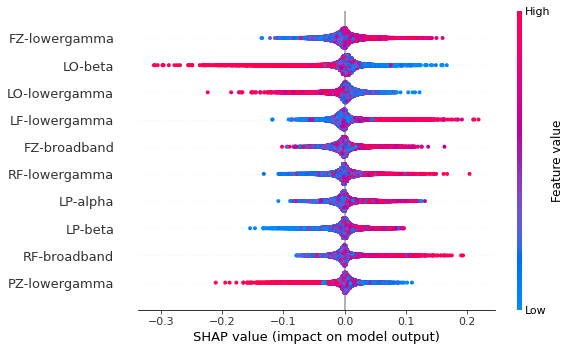

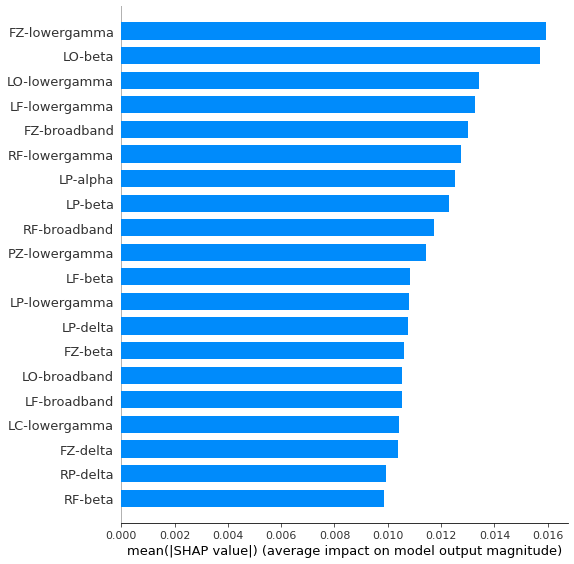

In [61]:
shap.summary_plot(shap_values.values[..., 1], X_test, max_display=10)
shap.summary_plot(shap_values.values[..., 1], X_test, plot_type='bar')

In [34]:
shap.initjs()
# shap.plots.force(0.52, shap_values[1], X)
shap.force_plot(.52, shap_values.values[..., 1], feature_names=X.columns, matplotlib=False)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


KeyboardInterrupt: 

In [ ]:
# TODO find a way to set the base value from the explainer.expected_value in permuted explainer

In [159]:
misclassified = np.where(y_test != y_pred)[0]
misclassified = shap.utils.sample(misclassified, 10, random_state=None)

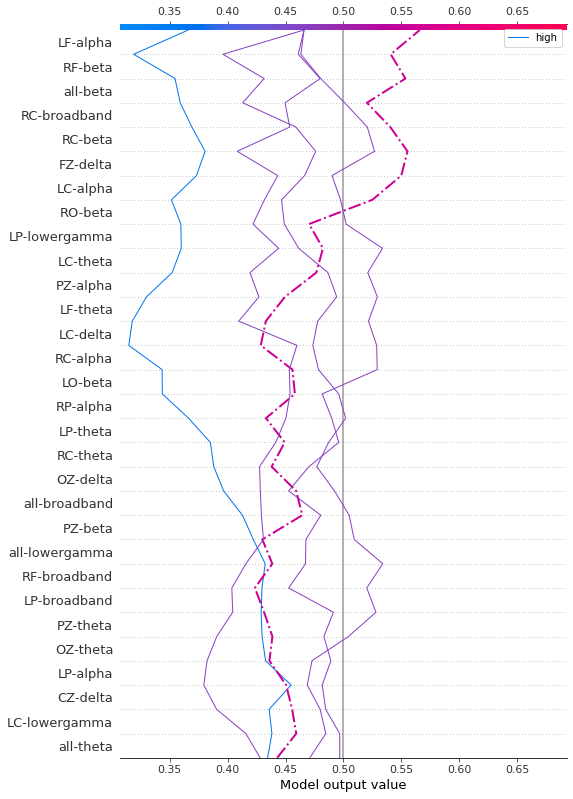

In [160]:
shap.plots.decision(.50,
                    shap_values.values[misclassified, :, 1],
                    X,
                    feature_display_range=slice(-1, -31, -1),
                    highlight=y.values[misclassified] == 'high',
                    legend_labels=['high'])